### 0. Import Libraries

In [393]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
import requests, json
from urllib.parse import quote

from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.utils import to_categorical

### 1. Load Data

In [429]:
dataset = load_data('XRP', 1, 100000)

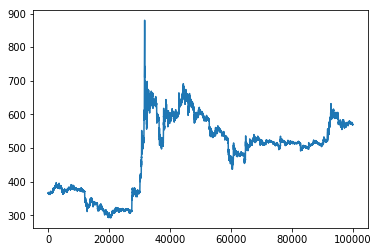

In [430]:
plt.plot(dataset[:,[6]].astype(float)) # todo : 플롯 스타팅 포인트(x) 바꿔그리기

### 2. Set constant values / hyperparameters

In [431]:
col=[6]
input_seq = 5
output_seq = 5
hidden = 128
padding = 0
batch_size = 256
epoch = 10

### 3. Process data / Split to train and test

In [432]:
#cardinality 세팅을 위한 데이터 패딩 처리
meta, data_origin, _, features, distance = feed_maker(dataset, col, scale=False)
data_padded = data_origin - distance
features = features + 1
x1, x2, y = get_processed_data(data_padded, input_seq, output_seq, features)
train, test = split_data(x1, x2, y, test_portion=0.1)

### 4. Build / Train Model

In [443]:
model, infenc, infdec = define_models(features, features, hidden)
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['acc']) #메트릭 MAE로 바꿔서 결과 비교해 보기

In [444]:
hist = model.fit([train[0], train[1]], train[2], batch_size=batch_size, epochs=epoch, validation_split=0.1)

Train on 80992 samples, validate on 9000 samples
Epoch 1/10
80992/80992 [==============================] - 78s 968us/step - loss: 3.1486 - acc: 0.2920 - val_loss: 1.1989 - val_acc: 0.5341
Epoch 2/10
80992/80992 [==============================] - 62s 767us/step - loss: 1.4954 - acc: 0.4609 - val_loss: 1.0419 - val_acc: 0.5805
Epoch 3/10
80992/80992 [==============================] - 59s 729us/step - loss: 1.3314 - acc: 0.5019 - val_loss: 0.9725 - val_acc: 0.6030
Epoch 4/10
80992/80992 [==============================] - 75s 925us/step - loss: 1.2682 - acc: 0.5172 - val_loss: 0.9564 - val_acc: 0.6107
Epoch 5/10
80992/80992 [==============================] - 71s 879us/step - loss: 1.2372 - acc: 0.5239 - val_loss: 0.9496 - val_acc: 0.6119
Epoch 6/10
80992/80992 [==============================] - 66s 815us/step - loss: 1.2173 - acc: 0.5284 - val_loss: 0.9446 - val_acc: 0.6083
Epoch 7/10
80992/80992 [==============================] - 55s 676us/step - loss: 1.2023 - acc: 0.5315 - val_loss: 0.9

### 5. Show trained result

89992/89992 [==============================] - 31s 343us/step
Loss: 1.1330914596672408 Acc: 0.5494866211916756


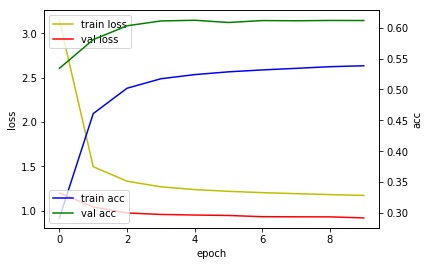

In [445]:
#results
test_model(model, [train[0], train[1]], train[2])

#graph
show_graph(hist)

### 6. Predict Future data using trained model

In [ ]:
test_predict = predict_data(test[0])

In [ ]:
show_result_samples(10, test_predict.shape[0])
eval_strict = get_eval_strict()
eval_isclose = get_eval_isclose(3)
eval_minmax = get_eval_minmax()
#업다운 추세에 대한 평가지표를 하나 더 추가. 이건 mse가 더 잘 어울리나? 일단은..

print('')
print('[Evaluation Results(%)]')
print('Strict Equality :%s, IsClose Equality :%s, MinMax Equality :%s'%(round(eval_strict,2), round(eval_isclose,2), round(eval_minmax,2)))

### 7. Todo
- mae metric 으로 다시 세팅해서 결과 보기 (categorical도 제대로 나와야 할 것 같긴 한데 loss 줄이는데 문제가 있는지 체크를..)

### 8. Reference : Functions

In [408]:
#new functions for seq_to_seq
#패딩된 데이터를 3개의 seq 데이터로 만들기
#x2가 여러개 있을 수 있는가?
def get_processed_data(data, input_seq, output_seq, features):
    
    origin = list()
    for i in range(len(data)-output_seq +1):
        origin.append(data[i:i+input_seq].reshape(1,-1)[0])
    origin = np.array(origin)
    source = origin[:-output_seq]
    target = origin[input_seq:]
    target_in = np.concatenate([np.zeros((target.shape[0],1)),target[:,0:output_seq-1]],axis=1)

    source_encoded = to_categorical(source,num_classes=features)
    target_encoded = to_categorical(target,num_classes=features)
    target_in_encoded = to_categorical(target_in,num_classes=features)

    return source_encoded, target_in_encoded, target_encoded
#    return source, target_in, target

#원핫 디코딩
def one_hot_decode(encoded_seq):
    return [np.argmax(vector) for vector in encoded_seq]

#모델 생성
def define_models(n_input, n_output, n_units):
    
    #인코더 정의
    encoder_inputs = Input(shape=(None, n_input))
    encoder = LSTM(n_units, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]
    
    #디코더 정의
    decoder_inputs = Input(shape=(None, n_output))
    decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(n_output, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    # infenc
    encoder_model = Model(encoder_inputs, encoder_states)
    
    # infdec
    decoder_state_input_h = Input(shape=(n_units,))
    decoder_state_input_c = Input(shape=(n_units,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
    
    # return all models
    return model, encoder_model, decoder_model

# 예측을 위한 함수들
def predict_sequence(infenc, infdec, data, n_steps, features):
    
    state = infenc.predict(data)
    target_seq = np.array([0.0 for _ in range(features)]).reshape(1, 1, features)
    
    output = list()
    for t in range(n_steps):
        predict, h, c = infdec.predict([target_seq] + state)
        output.append(predict[0,0,:])
        state = [h, c]
        target_seq = predict
    return np.array(output)

def predict_data(data):
    res = list()
    
    for i in range(len(data)):
        predict = predict_sequence(infenc, infdec, data[i].reshape(1,data[i].shape[0], data[i].shape[1]), output_seq, features)
        res.append(predict)
    
    return np.array(res)

In [441]:
#common functions
def call_candle(currency, minutes, count, to=''):
    max_count = 100

    if count > max_count:
        iter_range = count // max_count
        iter_left = count % max_count
        total = []

        while iter_range:
            to_encoded = quote(to)
            URL = 'https://api.upbit.com/v1/candles/minutes/' + str(
                minutes) + '?market=KRW-' + currency + '&count=' + str(max_count) + '&to=' + to_encoded
            req = requests.get(URL)
            res = json.loads(req.text)

            iter_range -= 1
            to = res[-1]['candle_date_time_kst'] + '+09:00'
            total += res

        if iter_left > 0:
            to_encoded = quote(to)
            URL = 'https://api.upbit.com/v1/candles/minutes/' + str(
                minutes) + '?market=KRW-' + currency + '&count=' + str(iter_left) + '&to=' + to_encoded
            req = requests.get(URL)
            res = json.loads(req.text)
            total += res

        return total
    else:
        to_encoded = quote(to)
        URL = 'https://api.upbit.com/v1/candles/minutes/' + str(
            minutes) + '?market=KRW-' + currency + '&count=' + str(count) + '&to=' + to_encoded
        req = requests.get(URL)
        res = json.loads(req.text)
        res.reverse()

        return res
    
def load_data(currencies, mins, counts):
    #loading data
    data_origin = call_candle(currencies, minutes=mins , count=counts, to='2018-11-11T23:00:00+09:00')
    data_array = []
    for i in data_origin:
        data_array.append(list(i.values()))
    data = np.array(data_array)
    data = data[data[:,2].argsort()] #sort by time
    return data

#seq 용으로 커스텀. 무조건 3*2 6개의 결과가 나오도록 되어 있음.
def split_data(x1, x2, y, test_portion=0.1):
    test_size = int(len(x1) * test_portion)
    train_x1, test_x1 = x1[:-test_size], x1[-test_size:]
    train_x2, test_x2 = x2[:-test_size], x2[-test_size:]
    train_y, test_y = y[:-test_size], y[-test_size:]
    
    return (train_x1, train_x2, train_y), (test_x1, test_x2, test_y)

def feed_maker(data, col, scale=True, is_training=True, v=None):
    if is_training == True:
        v = {}
    x = {}
    
    #Missing Value 핸들링 : 각 값들을 median value로 채움
    if scale == True:
        for i in range(len(col)):
            if is_training == True:
                v[i] = get_metadata(data[:,col][:,i].astype(float))
            x[i] = scale_value(data[:,col][:,i].astype(float), v[i], scale=True)
    else:
        for i in range(len(col)):
            x[i] = data[:,col][:,i].astype(float)
    
    x_val = np.transpose(np.array(list(x.values())))
    y_val = x_val[:,[0]]
    
    data_min, data_max = np.min(x_val), np.max(x_val)
    features = int(data_max - data_min + (2*padding))
    distance = data_min - padding
        
    return v, x_val, y_val, features, distance

def get_metadata(feature):
    obj = {}
    obj['min'] = feature.min()
    obj['max'] = feature.max()
        
    return obj

def scale_value(feature, meta, scale):
    #수동 스케일러
    if scale == True:
        def minmaxScaler(data, datamin, datamax):
            numerator = data - datamin
            denominator = datamax - datamin
            return numerator / (denominator + 1e-8)
        
        return minmaxScaler(feature, meta['min'], meta['max'])

    else:
        pass
    
def show_graph(hist):
    fig, loss_ax = plt.subplots()

    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

    acc_ax.plot(hist.history['acc'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_ylabel('acc')

    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')
    
def test_model(model, testX, testY):
    loss, metric = model.evaluate(testX, testY, verbose=1)
    print('Loss:',loss, 'Acc:', metric)

    
#평가 메소드
def show_result_samples(num, len_data):
    print('[Example Data]')
    d = list()
    for i in range(10):
        d.append(randint(1, len_data))
   
    for i in d:
        print('Index=%s X=%s y=%s, yhat=%s' % (i, one_hot_decode(test[0][i]), one_hot_decode(test[2][i]), one_hot_decode(test_predict[i])))
        
def get_eval_strict():
    total, correct = test_predict.shape[0], 0

    for i in range(len(test_predict)):
        if np.array_equal(one_hot_decode(test[2][i]), one_hot_decode(test_predict[i])):
                correct += 1
    return float(correct)/float(total)*100.0   
    
    
def get_eval_isclose(num):
    total, correct = test_predict.shape[0], 0

    for i in range(len(test_predict)):
        if np.isclose(one_hot_decode(test[2][i]), one_hot_decode(test_predict[i])).sum() >= num:
            correct += 1
    return float(correct)/float(total)*100.0
    
def get_eval_minmax():
    total, correct = test_predict.shape[0], 0

    for i in range(len(test_predict)):
        if (np.min(one_hot_decode(test[2][i])) == np.min(one_hot_decode(test_predict[i]))) and (np.max(one_hot_decode(test[2][i])) == np.max(one_hot_decode(test_predict[i]))):
            correct += 1
    return float(correct)/float(total)*100.0